<a href="https://colab.research.google.com/github/shpotes/traffic-counter/blob/loss/notebooks/loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU 


#◢ Git clone and install Faster R-CNN

In [1]:
!git clone https://github.com/shpotes/traffic-counter
%cd traffic-counter/notebooks

fatal: destination path 'traffic-counter' already exists and is not an empty directory.
/content/traffic-counter/notebooks


#◢ Setup

In [2]:
!pip install -r ../requirements.txt

In [0]:
import sys
import os
import json
from itertools import groupby
from operator import itemgetter
from typing import List, Tuple, Dict

import gin
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')

from vehicle_nowcasting.data.data_loader import build_source_from_metadata, generate_anchors, normalize
from vehicle_nowcasting.utils import iou, plot_bb

%matplotlib inline

##◢ Load metadata

In [0]:
main_dir = '..'
data_dir = os.path.join(main_dir, 'data')
metadata = pd.read_csv('../data/metadata.csv')
label_map = json.load(open('../data/label_map.json', 'r'))

In [0]:
sources = build_source_from_metadata(metadata,
                                     label_map,
                                     data_dir)

In [6]:
sources[:2]

[('../data/train/15-02-15-20:17.jpg',
  [(1, 225, 117, 411, 281),
   (3, 335, 212, 456, 329),
   (3, 555, 140, 607, 210),
   (4, 470, 211, 553, 307),
   (4, 442, 138, 519, 202),
   (4, 24, 238, 147, 334),
   (4, 166, 176, 244, 258),
   (4, 388, 110, 435, 167),
   (4, 505, 96, 557, 149),
   (1, 436, 39, 528, 126),
   (3, 546, 66, 593, 106),
   (3, 615, 59, 663, 99)]),
 ('../data/train/33.09-14-17:43.jpg',
  [(3, 378, 288, 579, 474),
   (3, 271, 7, 346, 58),
   (3, 558, 191, 704, 307),
   (3, 555, 132, 695, 214),
   (3, 405, 65, 498, 126),
   (3, 302, 75, 393, 135),
   (3, 227, 32, 293, 72),
   (3, 213, 1, 268, 26),
   (3, 71, 16, 120, 58),
   (2, 8, 39, 101, 155),
   (5, 83, 57, 109, 96),
   (5, 148, 143, 187, 203),
   (5, 150, 108, 191, 161),
   (5, 349, 373, 443, 477),
   (5, 310, 437, 384, 480)])]

In [0]:
images, bbox_raw = zip(*sources)

In [8]:
# Big issue!
bbox_raw[3:5]
# There are different number of bbox ergo 
# it will be quite hard to create a tf.Tensor

([(5, 166, 294, 242, 364),
  (3, 1, 201, 127, 315),
  (3, 188, 32, 245, 74),
  (3, 209, 6, 256, 39),
  (4, 111, 130, 185, 201)],
 [(3, 425, 264, 497, 334),
  (3, 274, 195, 317, 244),
  (3, 393, 166, 426, 207),
  (3, 440, 140, 470, 164),
  (3, 425, 115, 454, 137),
  (3, 383, 99, 404, 119),
  (3, 302, 234, 363, 303),
  (3, 333, 188, 384, 240),
  (3, 398, 186, 466, 250),
  (3, 492, 96, 524, 119),
  (3, 274, 162, 307, 200),
  (3, 368, 139, 408, 176),
  (3, 327, 163, 371, 199),
  (3, 305, 129, 347, 166),
  (3, 272, 130, 301, 164),
  (3, 292, 149, 325, 181),
  (3, 353, 126, 396, 155),
  (3, 344, 96, 375, 132),
  (5, 378, 269, 411, 341),
  (5, 391, 240, 419, 295)])

In [0]:
# Simple solution: pad that dimension
fill = -(1 << 31)
max_length = max(map(len, bbox_raw))
bbox_norm = list(map(lambda x: x + [(fill, fill, fill, fill, fill)
                                    for _ in range(max_length - len(x))],
                     bbox_raw))

In [10]:
bbox_norm[3:5]

[[(5, 166, 294, 242, 364),
  (3, 1, 201, 127, 315),
  (3, 188, 32, 245, 74),
  (3, 209, 6, 256, 39),
  (4, 111, 130, 185, 201),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2147483648, -2147483648),
  (-2147483648, -2147483648, -2147483648, -2

In [11]:
# Let's create the tf.data.Dataset!
ds = tf.data.Dataset.from_tensor_slices({
        'image': list(images),
        'bbox_info' : bbox_norm 
    })

ds

<TensorSliceDataset shapes: {image: (), bbox_info: (34, 5)}, types: {image: tf.string, bbox_info: tf.int32}>

In [12]:
def load(row: tf.data.Dataset) \
    -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Load dataset from a given reference
    
    (Yes, I'm a type-freak)
    """
    fill = tf.zeros(shape=(1, 5), dtype=tf.int32) - (1 << 31)
    mask = tf.not_equal(row['bbox_info'], fill)
    bbox = tf.boolean_mask(row['bbox_info'], mask)
    bbox = tf.reshape(bbox, shape=(-1, 5))
    filepath = row['image']
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img)
    return img, bbox

ds = ds.map(load) # (Image, bounding boxes)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Wait a second!
Why can you do that!? Why can you create the bbox tensor?<br>
> The map operation occurs on the device-site instead of the user-site, it doesn't allocate matrix in memory, just manage their reference. So at this point, it doesn't know (yet) if there is any mismatch on the dimension of their objects.

So... I can't create a batch from that tensor
> You can do it, but when a user interacts with the tensor, an error will appear

In [13]:
ds.batch(2)

<BatchDataset shapes: ((None, None, None, None), (None, None, 5)), types: (tf.uint8, tf.int32)>

In [14]:
next(iter(ds.batch(2)))

InvalidArgumentError: ignored

let's forget that for a moment

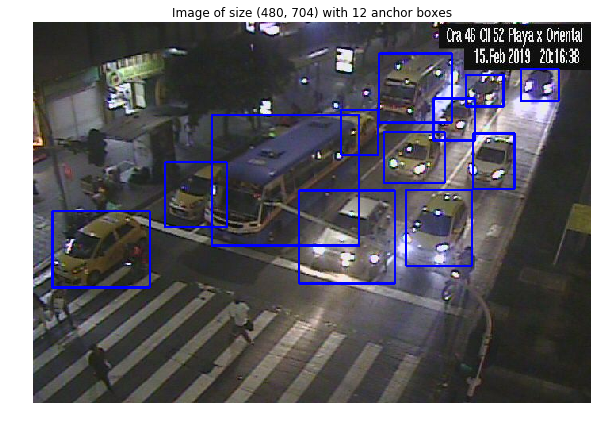

In [15]:
img, gt = next(iter(ds))
img = plot_bb(img.numpy(), gt.numpy(), (0, 0, 255), 2)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title('Image of size (%d, %d) with %d anchor boxes' % (*img.shape[:2], len(gt)))
plt.axis('off');

Now, we need a set of standardized (224, 224) images in order to compute the forward-pass through the backbone network

In [0]:
def preprocess_input(image, bbox, target_size=(224, 224)):
    """
    Rescale a given `image` to fixed `target_size`
    """
    size = 480, 704
    new_x, new_y = target_size
    
    img = tf.image.resize(image, (224, 224)) / 255

    # "Rescale" bbox is also needed 
    scale = tf.constant([1, new_x / size[1], new_y / size[0],
                         new_x / size[1], new_y / size[0]])
    bbox_gt = tf.cast(tf.round(tf.cast(bbox, tf.float32) * scale), tf.int32)
    
    return img, bbox_gt

In [0]:
ds = ds.map(preprocess_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


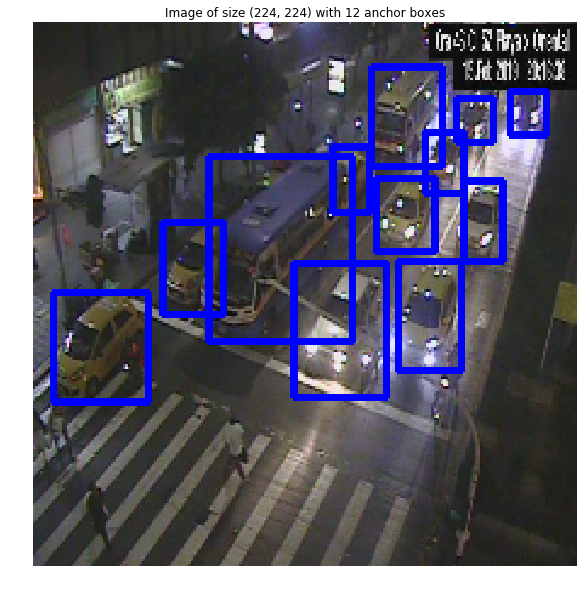

In [18]:
img, gt = next(iter(ds))
img = plot_bb(img.numpy(), gt.numpy(), (0, 0, 255), 2)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.title('Image of size (%d, %d) with %d anchor boxes' % (*img.shape[:2], len(gt)))
plt.axis('off');

##◢ Anchor boxes

In [19]:
anchors = generate_anchors(base_size=4,
                               ratios=[1, 1.25, 1.5, 1.75, 2],
                               scales=2 ** np.arange(3, 7))
anchors = anchors[((anchors > 0) & (anchors < 244)).all(axis=-1), :]
anchors = tf.constant(anchors, dtype=tf.int32)

anchors.shape

TensorShape([3508, 4])

##◢ Compute positive and negative examples 

In [20]:
iou_matrix = iou(anchors, gt[:, 1:])
iou_matrix.shape

TensorShape([3508, 12])

In [21]:
# Assign a positive label to the anchor with the highest IoU
max_score = tf.reduce_max(iou_matrix, axis=0)
best_loc = tf.cast(tf.where(iou_matrix == max_score), dtype=tf.int32)
best_bbox = tf.gather(anchors, best_loc[:, 0])
print(best_bbox.shape)

# Instead of stores the GT class, 
# store a reference to the GT.
# We will need all the GT bbox
# information in order to compute the loss
best_gt_pointer = tf.reshape(best_loc[:, 1], shape=[-1, 1])

best = tf.concat([best_gt_pointer, best_bbox], axis=1)

print(best.shape)

(14, 4)
(14, 5)


In [0]:
# Assign a positive label to an anchor that has an IoU > 0.7
pos_cond = iou_matrix > 0.7
pos_mask = tf.reduce_any(pos_cond, axis=1)
pos_bbox = tf.boolean_mask(anchors, pos_mask)

pos_gt_pointer = tf.reshape(tf.where(pos_cond)[:, 1], shape=[-1, 1])
pos_gt_pointer = tf.cast(pos_gt_pointer, tf.int32)

pos = tf.concat([pos_gt_pointer, pos_bbox], axis=1)

In [0]:
# Assign a negative label to an anchor that has an IoU < 0.3
neg_cond = iou_matrix < 0.3
neg_mask = tf.reduce_any(neg_cond, axis=1)
neg_bbox = tf.boolean_mask(anchors, neg_mask)

# There are not a GT for this boxes, so just fill
neg_gt_pointer = tf.zeros((len(neg_bbox), 1), tf.int32) - 1 

neg = tf.concat([neg_gt_pointer, neg_bbox], axis=1)

In [0]:
anchor_boxes = tf.concat([pos, neg, best], axis=0)

In [25]:
anchor_boxes

<tf.Tensor: id=252, shape=(3536, 5), dtype=int32, numpy=
array([[  9, 136,  22, 167,  61],
       [  9, 140,  18, 163,  65],
       [  0,  70,  42, 133, 121],
       ...,
       [  3, 150,  98, 173, 145],
       [  5,  16, 112,  47, 151],
       [  1,  98, 100, 145, 163]], dtype=int32)>

In [0]:
def compute_anchor_boxes(anchors, img, bbox_gt):
    iou_matrix = iou(anchors, gt[:, 1:])

    # Assign a positive label to the anchor with the highest IoU
    max_score = tf.reduce_max(iou_matrix, axis=0)
    best_loc = tf.cast(tf.where(iou_matrix == max_score), dtype=tf.int32)
    best_bbox = tf.gather(anchors, best_loc[:, 0])

    # Instead of stores the GT class, 
    # store a reference to the GT.
    # We will need all the GT bbox
    # information in order to compute the loss
    best_gt_pointer = tf.reshape(best_loc[:, 1], shape=[-1, 1])

    best = tf.concat([best_gt_pointer, best_bbox], axis=1)

    # Assign a positive label to an anchor that has an IoU > 0.7
    pos_cond = iou_matrix > 0.7
    pos_mask = tf.reduce_any(pos_cond, axis=1)
    pos_bbox = tf.boolean_mask(anchors, pos_mask)

    pos_gt_pointer = tf.reshape(tf.where(pos_cond)[:, 1], shape=[-1, 1])
    pos_gt_pointer = tf.cast(pos_gt_pointer, tf.int32)

    pos = tf.concat([pos_gt_pointer, pos_bbox], axis=1)
    
    # Assign a negative label to an anchor that has an IoU < 0.3
    neg_cond = iou_matrix < 0.3
    neg_mask = tf.reduce_any(neg_cond, axis=1)
    neg_bbox = tf.boolean_mask(anchors, neg_mask)

    # There are not a GT for this boxes, so just fill
    neg_gt_pointer = tf.zeros((len(neg_bbox), 1), tf.int32) - 1 

    neg = tf.concat([neg_gt_pointer, neg_bbox], axis=1)
    
    anchor_bbox = tf.concat([pos, neg, best], axis=0)

    return img, anchor_bbox, bbox_gt

In [27]:
anchors = generate_anchors(base_size=4,
                               ratios=[1, 1.25, 1.5, 1.75, 2],
                               scales=2 ** np.arange(3, 7))
anchors = anchors[((anchors > 0) & (anchors < 244)).all(axis=-1), :]
anchors = tf.constant(anchors, dtype=tf.int32)

ds = ds.map(lambda img, bbox_gt: 
            compute_anchor_boxes(anchors, img, bbox_gt))

ds # img, anchor_bbox, bbox_gt

<MapDataset shapes: ((224, 224, None), (None, 5), (None, 5)), types: (tf.float32, tf.int32, tf.int32)>

In [0]:
img, anchor_bbox, bbox_gt = next(iter(ds))
img = img.numpy()
anchors = anchor_bbox.numpy()
gt = bbox_gt.numpy()

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


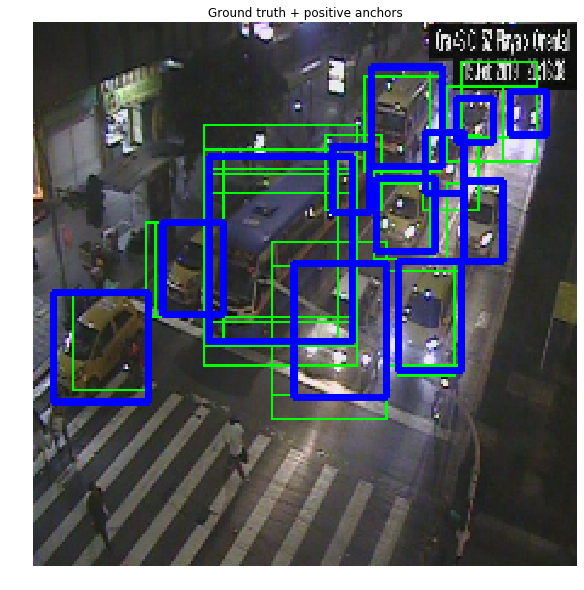

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

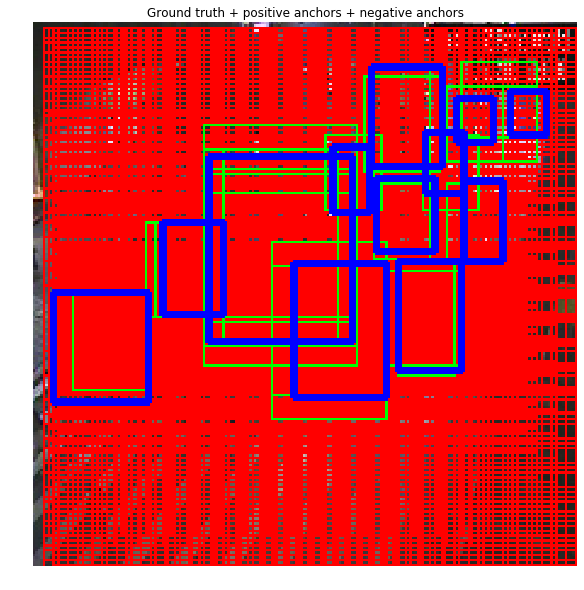

In [29]:
img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, gt, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.title('Ground truth + positive anchors')
plt.imshow(img)
plt.axis('off')
plt.show()

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)
img = plot_bb(img, gt, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.title('Ground truth + positive anchors + negative anchors')
plt.imshow(img)
plt.axis('off')

Jmmmmmm there are **A LOT** of red boxes, thus, if we try to train a model with that set, it would be an obvious bias toward false boxes.

let's try with hierarchical sampling

In [0]:
def hierarchical_sampling(img, anchors, gt, batch_size, N_sampling=1):
    """
    Implementation notes:
    Increase N_sampling makes quite difficult to trace the image
    """

    positive_mask = anchors[:, :, 0] != -1
    batch_positive = tf.boolean_mask(anchors, positive_mask)
    batch_positive = tf.random.shuffle(batch_positive)
    batch_positive_size = tf.math.minimum(len(batch_positive), batch_size // 2)
    batch_positive = batch_positive[:batch_positive_size, :]

    negative_mask = anchors[:, :, 0] == -1
    batch_negative = tf.boolean_mask(anchors, negative_mask)
    batch_negative = tf.boolean_mask(batch_negative, # Remove pad
                                     tf.reduce_any(batch_negative != 0, axis=1))
    batch_negative = tf.random.shuffle(batch_negative)
    batch_negative_size = batch_size - batch_positive_size
    batch_negative = batch_negative[:batch_negative_size, :]

    batch = tf.concat([batch_positive, batch_negative], axis=0)
    batch = tf.random.shuffle(batch)
    return img, batch, gt

In [0]:
ds_new = ds.repeat(count=1)
ds_new = ds_new.padded_batch(1, ([224, 224, None], [None, 5], [None, 5]))
ds_new = ds_new.map(lambda img, anchors, gt:
            hierarchical_sampling(img, anchors, gt, batch_size=32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


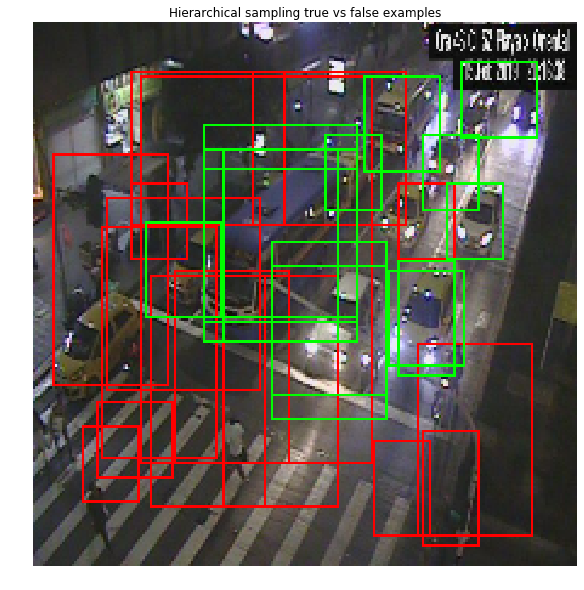

In [32]:
tensor = next(iter(ds_new))
anchors = tensor[1].numpy()
img = tensor[0].numpy()[0, :, :]

neg = anchors[anchors[:, 0] == -1]
pos = anchors[anchors[:, 0] != -1]

img = plot_bb(img, neg, (255, 0, 0), 1)
img = plot_bb(img, pos, (0, 255, 0), 1)

plt.figure(figsize = (10,10))
plt.imshow(img)
plt.axis('off')
plt.title('Hierarchical sampling true vs false examples');

In [0]:
from vehicle_nowcasting.data.generate_anchors import generate_anchors as gen_anch
from vehicle_nowcasting.utils import change_box_order

In [0]:
anch = tf.cast(next(iter(ds_new))[1][:, 1:], tf.float64)

In [0]:
anchors = tf.constant(gen_anch(base_size=4,
                               ratios=[1, 1.25, 1.5, 1.75, 2],
                               scales=2 ** np.arange(3, 7)))

In [0]:
anch = change_box_order(anch, 'xyxy2xywh')

In [0]:
anchors = change_box_order(anchors, 'xyxy2xywh')

In [50]:
anch

<tf.Tensor: id=620, shape=(32, 4), dtype=float64, numpy=
array([[ 61.5, 101.5,  63. ,  63. ],
       [191.5,  31.5,  31. ,  31. ],
       [ 21.5, 161.5,  23. ,  31. ],
       [101.5,  81.5,  63. ,  79. ],
       [ 51.5, 131.5,  63. ,  79. ],
       [171.5,  61.5,  23. ,  31. ],
       [101.5, 101.5,  63. ,  63. ],
       [141.5, 111.5, 127. , 127. ],
       [141.5, 121.5,  47. ,  95. ],
       [151.5,  81.5,  23. ,  31. ],
       [ 21.5, 131.5,  23. ,  47. ],
       [101.5, 151.5,  95. , 159. ],
       [151.5,  81.5,  23. ,  31. ],
       [161.5, 121.5,  23. ,  39. ],
       [ 81.5, 181.5,  47. ,  63. ],
       [161.5, 121.5,  23. ,  47. ],
       [131.5,  61.5,  23. ,  31. ],
       [ 61.5, 101.5,  31. ,  39. ],
       [ 71.5, 161.5,  31. ,  31. ],
       [181.5, 121.5,  23. ,  47. ],
       [101.5,  91.5,  47. ,  79. ],
       [ 81.5,  71.5,  31. ,  39. ],
       [161.5, 121.5,  31. ,  39. ],
       [151.5,  41.5,  23. ,  47. ],
       [141.5, 121.5,  23. ,  47. ],
       [191.5, 141

In [0]:
cond = tf.reshape(anch[:, 2:], (-1, 1, 2)) - tf.reshape(anchors[:, 2:], (1, -1, 2))
anchor_map = tf.where(tf.reduce_all(tf.abs(cond) < 1e-7, axis=-1))

<tf.Tensor: id=938, shape=(32, 2), dtype=int64, numpy=
array([[ 0,  1],
       [ 1,  0],
       [ 2,  8],
       [ 3,  5],
       [ 4,  5],
       [ 5,  8],
       [ 6,  1],
       [ 7,  2],
       [ 8, 17],
       [ 9,  8],
       [10, 16],
       [11, 14],
       [12,  8],
       [13, 12],
       [14,  9],
       [15, 16],
       [16,  8],
       [17,  4],
       [18,  0],
       [19, 16],
       [20, 13],
       [21,  4],
       [22,  4],
       [23, 16],
       [24, 16],
       [25, 12],
       [26,  5],
       [27,  9],
       [28,  6],
       [29,  0],
       [30, 14],
       [31,  5]])>

In [0]:
cond

In [0]:
tf.reduce_all(cond, axis=1)

In [0]:
anchors[:, 2:]

In [0]:
anchors = tf.constant(gen_anch(base_size=4,
                               ratios=[1, 1.25, 1.5, 1.75, 2, 2.25, 2.5],
                               scales=2 ** np.arange(3, 10)))

In [0]:
tf.where(cond)